['List_ACIE_THF', 'List_ACIE_THP', 'HongAckermann_NatSyn', 'Sunoj_PNAS']
Worse than baseline: List_ACIE_THF_LinearRegression-fp_ee_withT.csv with MAE: 355841587066.95685 and RMSE: 411121019941.0712
Worse than baseline: List_ACIE_THF_LinearRegression-descriptors_ee_withT.csv with MAE: 121434404007.43329 and RMSE: 125436329644.34946
Worse than baseline: List_ACIE_THF_LinearRegression-descriptors_ee_withoutT.csv with MAE: 477698522496.01843 and RMSE: 633630920879.8035
Worse than baseline: List_ACIE_THF_LinearRegression-fp_ee_withoutT.csv with MAE: 102142769098.5069 and RMSE: 112801931806.32005
List_ACIE_THF:
fp_withoutT: 0.3870092044605747
fp_withT: 0.3812276939758872
desc_lin_withoutT: 0.23908349439813167
desc_lin_withT: 0.23719359136674012
desc_nlin_withoutT: 0.31091318371713916
desc_nlin_withT: 0.3122972903579732
gnn_withoutT: 0.8192355717132104
gnn_withT: 0.7572693763459794
--------------------------------------------------
Worse than baseline: List_ACIE_THP_LinearRegression-fp_ee_wit

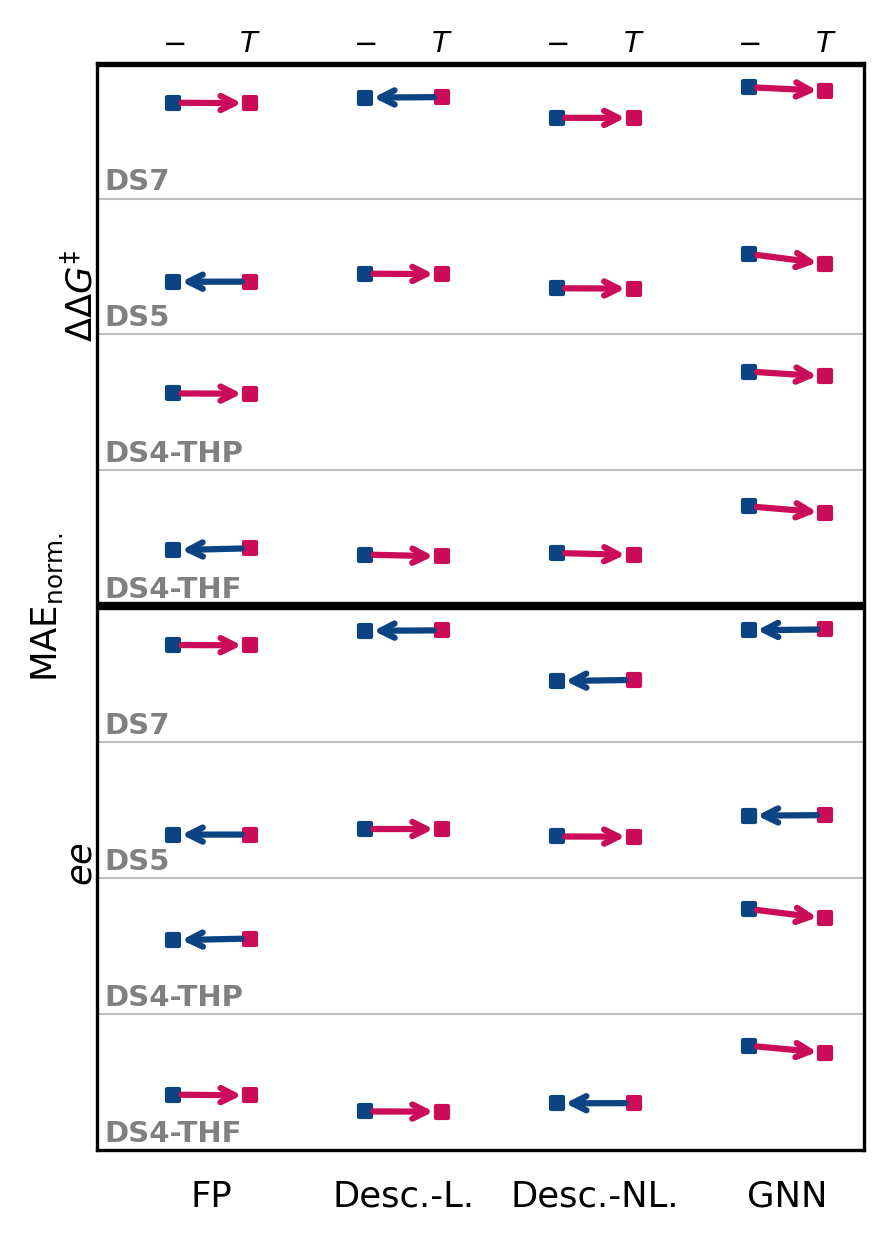

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import os
import pandas as pd
fontsize = 8.5
markersize = 8.5
x_offset = 0.24
arrow_width = 1.5
error = 0
extra_y_offset = 0.1
sec_axis_offset = -0.21
text_offset = 0.05
sec_axis_fontsize = 7

plt.figure(figsize=(3.3,8*0.6), dpi=300)

path_files = 'predictions_mr_best'
mode = 'MAE' # MAE, RMSE, R2, er 

gensch_palette = ['#0C4383',
                '#22A0B6',
                '#46E0A6',
                '#7B1346',
                '#CB0C59']
plt.style.use('default')
plt.rcParams['font.size'] =fontsize

# all possible combinations
dataset_list = ['HongAckermann_NatSyn', 'List_ACIE_THF', 'List_ACIE_THP',  'Sunoj_PNAS']

dataset_dict = {
    'Order' : 'Order',
    'SigmanBiscoe_Science' : 'DS1',
    'Doyle_JACS' : 'DS2',
    'SigmanToste_JACS': 'DS3',
    'SigmanToste_Science' : 'DS6',
    'Sunoj_PNAS' : 'DS7',
    'Denmark_Science' : 'DS10',
    'Denmark_OPRD' : 'DS9',
    'Sunoj_JPC': 'DS8',
    'HongAckermann_NatSyn' : 'DS5',
    'List_ACIE_THP' : 'DS4-THP',
    'List_ACIE_THF' : 'DS4-THF',}

modes = ['fp',
         'descriptors',
         'GNN']
targets = ['ee',
           'ddg']
tmodes = ['withT',
          'withoutT']
methods = ['ElasticNetCV',
           'ExtraTreesRegressor',
           'GaussianProcess',
           'GradientBoostingRegressor',
           'KernelRidge_poly',
           'KernelRidge_rbf',
           'KNeighborsRegressor',
           'LassoCV',
           'LinearRegression',
           'RandomForestRegressor',
           'RidgeCV',
           'GNN']
lin_methods = ['ElasticNetCV',
               'LassoCV',
               'LinearRegression',
                'RidgeCV']
nonlin_methods = ['ExtraTreesRegressor',
                    'GaussianProcess',
                    'GradientBoostingRegressor',
                    'KernelRidge_poly',
                    'KernelRidge_rbf',
                    'KNeighborsRegressor',
                    'RandomForestRegressor',
                    'GNN']

best_models = {
    'Order' : ['FP', 'Desc-Lin', 'Desc-Nonlin', 'GNN'],
    'Denmark_Science' : [],
    'Doyle_JACS' : [],
    'HongAckermann_NatSyn' : [],
    'List_ACIE_THF' : [],
    'List_ACIE_THP' : [],
    'SigmanBiscoe_Science' : [],
    'SigmanToste_JACS' : [],
    'SigmanToste_Science' : [],
    'Sunoj_JPC': [],
    'Sunoj_PNAS' : [],
}

def ee2er(ee):
    '''
    ee in %
    '''
    epsilon = 1e-7 #  for numerical stability
    er = (1 + ee/100) / (1 - ee/100 + epsilon)

    return er

def ddg2er(ddg, T):
    '''
    ddg in kcal/mol
    T in Kelvin
    er = exp(-ddg/RT)
    ee = 100 * (er - 1) / (er + 1)
    '''
    # prevent overflow
    if ddg > 10:
        ddg = 10
    T = float(T)
    R_const = 8.31446261815324/1000 # kJ / (mol K)
    ddg *= 4.1839954 # convert from kcal/mol to kJ/mol
    er = np.exp(ddg / (R_const * T))
    return er


def calc_switch(dataframe, T_frame, tc):
    df_switched = pd.DataFrame()
    tc_sw = 'something_wrong_in_switching'
    df_list = []
    dataframe['T'] = T_frame['T']
    for col in dataframe.columns:
        if col != 'T':
            if tc == 'ee':
                df_col = dataframe.apply(lambda row: ee2er(row[col]), axis=1)
                tc_sw = 'ddg'
            else:
                df_col = dataframe.apply(lambda row: ddg2er(row[col], row['T']), axis=1)
                tc_sw = 'ee'
            df_list.append(df_col)
    df_switched = pd.concat(df_list, axis=1)
    dataframe = dataframe.drop(columns=['T'])
    df_switched.columns = dataframe.columns
    
    return df_switched

def load_both_datasets_v2(dataset, prediction_dataset):

    # original data
    df_orig = pd.read_csv(f'../datasets/{dataset}.csv')
    df_pred = pd.read_csv(prediction_dataset, delimiter=',')
    df_pred = df_pred.dropna(axis=1, how='any')

    return df_orig, df_pred

def calc_baseline(dataframe, tc):
    mean_val = dataframe[tc].mean()
    diff = dataframe[tc] - mean_val
    mae_baseline = abs(diff).mean()
    rmse_baseline = np.sqrt((diff**2).mean())
    # calc r2 baseline
    r2_baseline = r2_score(dataframe[tc], np.ones(len(dataframe))*mean_val)
    return mae_baseline, rmse_baseline, r2_baseline

def calc_metrics(data_orig, data_pred, only_test = True, baselines = None):
    '''
    baselines = [mae_baseline, rmse_baseline]
    '''
    # only from test set
    maes = []
    rmses = []
    r2s = []
    for col in data_pred.columns:
        if not 'Unnamed' in col and not 'T' in col:
            if only_test:
                train_idx, test_idx = train_test_split(range(len(data_pred)), test_size = 0.2, random_state = int(col))
                data_pred_test = data_pred[col].iloc[test_idx]
                data_orig_test = data_orig.iloc[test_idx]
            else:
                data_pred_test = data_pred[col]
                data_orig_test = data_orig
            mae = mean_absolute_error(data_orig_test, data_pred_test)
            rmse = np.sqrt(mean_squared_error(data_orig_test, data_pred_test))
            r2 = r2_score(data_orig_test, data_pred_test)

            if baselines != None:
                mae = mae / baselines[0]
                rmse = rmse / baselines[1]
                r2 = r2 / (baselines[2] + 1e-7)

            maes.append(mae)
            rmses.append(rmse)
            r2s.append(r2)

    mae = np.mean(maes)
    rmse = np.mean(rmses)
    r2 = np.mean(r2s)
    return mae, rmse, r2

# list all files in folder
files = os.listdir(f'../{path_files}/')

# first the best models for each dataset have to be found
# rubriks are FP, Desciptors-Lin., Descriptors-Nonlin., GNN

#sort dataset by order given in dataset_dict
dataset_list = sorted(dataset_list, key=lambda x: int(dataset_dict[x][:4].replace('DS','').replace('-','')))
print(dataset_list)

i = 0
for tc in targets:
    for dataset in dataset_list:
        metric = 1337
        fp_withoutT_values = []
        fp_withT_values = []
        fp_withoutT_file_list = []
        fp_withT_file_list = []

        desc_lin_withoutT_values = []
        desc_lin_withT_values = []
        desc_lin_withoutT_file_list = []
        desc_lin_withT_file_list = []

        desc_nlin_withoutT_values = []
        desc_nlin_withT_values = []
        desc_nlin_withoutT_file_list = []
        desc_nlin_withT_file_list = []

        gnn_withoutT_values = []
        gnn_withT_values = []
        gnn_withoutT_file_list = []
        gnn_withT_file_list = []

        for tm in tmodes:
            for f in files:
                if dataset in f and tm in f and tc in f:
                    prediction_dataset = f'../{path_files}/{f}'
                    df_orig, df_preds = load_both_datasets_v2(dataset,
                                            prediction_dataset)
                    if mode != 'er':
                        mae_baseline, rmse_baseline, r2_baseline = calc_baseline(df_orig, tc)
                        mae, rmse, r2 = calc_metrics(df_orig[tc],
                                                    df_preds,
                                                    only_test = True,
                                                    baselines=[mae_baseline,
                                                                rmse_baseline, 
                                                                r2_baseline])
                    else:
                        if 'ee' in f:
                            df_orig[tc] = df_orig[tc].apply(lambda x: ee2er(x))
                        elif 'ddg' in f:
                            df_orig[tc] = df_orig.apply(lambda row: ddg2er(row[tc], row['T']), axis=1)

                        df_preds = calc_switch(df_preds, df_orig, tc)
                        mae_baseline, rmse_baseline, r2_baseline = calc_baseline(df_orig, tc)
                        mae, rmse, r2 = calc_metrics(df_orig[tc],
                                                    df_preds,
                                                    only_test = True,
                                                    baselines=[mae_baseline,
                                                                rmse_baseline,
                                                                r2_baseline])
                    if mode == 'MAE':
                        metric = mae
                    elif mode == 'RMSE':
                        metric = rmse
                    elif mode == 'R2':
                        metric = r2
                    elif mode == 'er':
                        metric = mae
                    if metric < 0:
                        print(f'Metric below 0, something wrong')
                    # worse than baseline should not be the best model
                    if metric > 1 + error: 
                        print(f'Worse than baseline: {f} with MAE: {mae} and RMSE: {rmse}')
                        metric = 1.0

                    if tm == 'withoutT':
                        if 'fp' in f:
                            fp_withoutT_values.append(metric)
                            fp_withoutT_file_list.append(f)
                        elif 'descriptor' in f:
                            # check if one of lin list is in f
                            if any(x in f for x in lin_methods):
                                desc_lin_withoutT_values.append(metric)
                                desc_lin_withoutT_file_list.append(f)

                            else:
                                desc_nlin_withoutT_values.append(metric)
                                desc_nlin_withoutT_file_list.append(f)
                        elif 'GNN' in f:
                            gnn_withoutT_values.append(metric)
                            gnn_withoutT_file_list.append(f)

                    elif tm == 'withT':
                        if 'fp' in f:
                            fp_withT_values.append(metric)
                            fp_withT_file_list.append(f)
                        elif 'descriptor' in f:
                            # check if one of lin list is in f
                            if any(x in f for x in lin_methods):
                                desc_lin_withT_values.append(metric)
                                desc_lin_withT_file_list.append(f)
                            else:
                                desc_nlin_withT_values.append(metric)
                                desc_nlin_withT_file_list.append(f)
                        elif 'GNN' in f:
                            gnn_withT_values.append(metric)
                            gnn_withT_file_list.append(f)
            

        # sort files by best for later investigations
        fp_withoutT_file_list = [x for _,x in sorted(zip(fp_withoutT_values,fp_withoutT_file_list))]
        fp_withT_file_list = [x for _,x in sorted(zip(fp_withT_values,fp_withT_file_list))]
        desc_lin_withoutT_file_list = [x for _,x in sorted(zip(desc_lin_withoutT_values,desc_lin_withoutT_file_list))]
        desc_lin_withT_file_list = [x for _,x in sorted(zip(desc_lin_withT_values,desc_lin_withT_file_list))]
        desc_nlin_withoutT_file_list = [x for _,x in sorted(zip(desc_nlin_withoutT_values,desc_nlin_withoutT_file_list))]
        desc_nlin_withT_file_list = [x for _,x in sorted(zip(desc_nlin_withT_values,desc_nlin_withT_file_list))]
        gnn_withoutT_file_list = [x for _,x in sorted(zip(gnn_withoutT_values,gnn_withoutT_file_list))]
        gnn_withT_file_list = [x for _,x in sorted(zip(gnn_withT_values,gnn_withT_file_list))]


        # sometimes any list could be empty because not all datasets have predictions
        # in this case we just add an empty string to the list
        if len(fp_withoutT_file_list) == 0:
            fp_withoutT_file_list.append(f'not_trained_for_{dataset}')
        if len(fp_withT_file_list) == 0:
            fp_withT_file_list.append(f'not_trained_for_{dataset}')
        if len(desc_lin_withoutT_file_list) == 0:
            desc_lin_withoutT_file_list.append(f'not_trained_for_{dataset}')
        if len(desc_lin_withT_file_list) == 0:
            desc_lin_withT_file_list.append(f'not_trained_for_{dataset}')
        if len(desc_nlin_withoutT_file_list) == 0:
            desc_nlin_withoutT_file_list.append(f'not_trained_for_{dataset}')
        if len(desc_nlin_withT_file_list) == 0:
            desc_nlin_withT_file_list.append(f'not_trained_for_{dataset}')
        if len(gnn_withoutT_file_list) == 0:
            gnn_withoutT_file_list.append(f'not_trained_for_{dataset}')
        if len(gnn_withT_file_list) == 0:
            gnn_withT_file_list.append(f'not_trained_for_{dataset}')

        # also sort the maes and rmses
        fp_withoutT_values = sorted(fp_withoutT_values)
        fp_withT_values = sorted(fp_withT_values)
        desc_lin_withoutT_values = sorted(desc_lin_withoutT_values)
        desc_lin_withT_values = sorted(desc_lin_withT_values)
        desc_nlin_withT_values = sorted(desc_nlin_withT_values)
        desc_nlin_withoutT_values = sorted(desc_nlin_withoutT_values)
        gnn_withoutT_values = sorted(gnn_withoutT_values)
        gnn_withT_values = sorted(gnn_withT_values)

        # maes will be filled if empty with 1337 so they are outside of plot range
        if len(fp_withoutT_values) == 0:
            fp_withoutT_values.append(1337)
        if len(fp_withT_values) == 0:
            fp_withT_values.append(1337)
        if len(desc_lin_withoutT_values) == 0:
            desc_lin_withoutT_values.append(1337)
        if len(desc_lin_withT_values) == 0:
            desc_lin_withT_values.append(1337)
        if len(desc_nlin_withoutT_values) == 0:
            desc_nlin_withoutT_values.append(1337)
        if len(desc_nlin_withT_values) == 0:
            desc_nlin_withT_values.append(1337)
        if len(gnn_withoutT_values) == 0:
            gnn_withoutT_values.append(1337)
        if len(gnn_withT_values) == 0:
            gnn_withT_values.append(1337)

        # store in best_models dict
        best_models[dataset] = {'fp_withoutT': fp_withoutT_file_list[0],
                                'fp_withT': fp_withT_file_list[0],
                                'desc_lin_withoutT': desc_lin_withoutT_file_list[0],
                                'desc_lin_withT': desc_lin_withT_file_list[0],
                                'desc_nlin_withoutT': desc_nlin_withoutT_file_list[0],
                                'desc_nlin_withT': desc_nlin_withT_file_list[0],
                                'gnn_withoutT': gnn_withoutT_file_list[0],
                                'gnn_withT': gnn_withT_file_list[0]}
        
        # its a scatter plot with connecting lines
        # following order fp_withoutT, fp_withT, desc_lin_withoutT, desc_lin_withT, desc_nlin_withoutT, desc_nlin_withT, gnn_withoutT, gnn_withT
        # only the best mae is plotted for each method
        # seperated by 1 in each method (fp, etc.) and by 1.5 inter-method
        # the y axis is the MAE or RMSE, depening on the mode chosen
        # for each dataset the y axis is incremented by i, so that the datasets are seperated and stacked on top of each other
        # the x axis is the method, seperated by 1.5
        # the x axis is incremented by j, so that the methods are seperated and stacked on top of each other
        # the color is the target withoutT or withT

        plt.scatter([1], [fp_withoutT_values[0] + i + extra_y_offset + i*2*extra_y_offset], color=gensch_palette[0], s=markersize, marker='s', edgecolors=gensch_palette[0])
        plt.scatter([2], [fp_withT_values[0] + i + extra_y_offset + i*2*extra_y_offset], color=gensch_palette[4], s=markersize, marker='s', edgecolors=gensch_palette[4])
        plt.scatter([3.5], [desc_lin_withoutT_values[0] + i + extra_y_offset + i*2*extra_y_offset], color=gensch_palette[0], s=markersize, marker='s', edgecolors=gensch_palette[0])
        plt.scatter([4.5], [desc_lin_withT_values[0] + i + extra_y_offset + i*2*extra_y_offset], color=gensch_palette[4], s=markersize, marker='s', edgecolors=gensch_palette[4])
        plt.scatter([6], [desc_nlin_withoutT_values[0] + i + extra_y_offset + i*2*extra_y_offset], color=gensch_palette[0], s=markersize, marker='s', edgecolors=gensch_palette[0])
        plt.scatter([7], [desc_nlin_withT_values[0] + i + extra_y_offset + i*2*extra_y_offset], color=gensch_palette[4], s=markersize, marker='s', edgecolors=gensch_palette[4])
        plt.scatter([8.5], [gnn_withoutT_values[0] + i + extra_y_offset + i*2*extra_y_offset], color=gensch_palette[0], s=markersize, marker='s', edgecolors=gensch_palette[0])
        plt.scatter([9.5], [gnn_withT_values[0] + i + extra_y_offset + i*2*extra_y_offset], color=gensch_palette[4], s=markersize, marker='s', edgecolors=gensch_palette[4])

        # print out all the values for the current dataset
        print(f'{dataset}:')
        print(f'fp_withoutT: {fp_withoutT_values[0]}')
        print(f'fp_withT: {fp_withT_values[0]}')
        print(f'desc_lin_withoutT: {desc_lin_withoutT_values[0]}')
        print(f'desc_lin_withT: {desc_lin_withT_values[0]}')
        print(f'desc_nlin_withoutT: {desc_nlin_withoutT_values[0]}')
        print(f'desc_nlin_withT: {desc_nlin_withT_values[0]}')
        print(f'gnn_withoutT: {gnn_withoutT_values[0]}')
        print(f'gnn_withT: {gnn_withT_values[0]}')
        print('-'*50)
        # now connected by lines with arrow heads
        if fp_withoutT_values[0] > fp_withT_values[0]:
            arrow_style = '<-'
            color = gensch_palette[4]
        elif fp_withoutT_values[0] < fp_withT_values[0]:
            arrow_style = '->'
            color = gensch_palette[0]
        else:
            arrow_style = '<->'
            color = gensch_palette[2]
        plt.annotate("", xy=(1, fp_withoutT_values[0] + i + extra_y_offset + i*2*extra_y_offset), xytext=(2, fp_withT_values[0] + i + extra_y_offset + i*2*extra_y_offset), arrowprops=dict(arrowstyle=arrow_style,
                                                                                                    lw=arrow_width,
                                                                                                    color=color))
        if desc_lin_withoutT_values[0] > desc_lin_withT_values[0]:
            arrow_style = '<-'
            color = gensch_palette[4]
        elif desc_lin_withoutT_values[0] < desc_lin_withT_values[0]:
            arrow_style = '->'
            color = gensch_palette[0]
        else:
            arrow_style = '<->'
            color = gensch_palette[2]
        plt.annotate("", xy=(3.5, desc_lin_withoutT_values[0] + i + extra_y_offset + i*2*extra_y_offset), xytext=(4.5, desc_lin_withT_values[0] + i + extra_y_offset + i*2*extra_y_offset), arrowprops=dict(arrowstyle=arrow_style,
                                                                                                                    lw=arrow_width,
                                                                                                                    color=color))
        if desc_nlin_withoutT_values[0] > desc_nlin_withT_values[0]:
            arrow_style = '<-'
            color = gensch_palette[4]
        elif desc_nlin_withoutT_values[0] < desc_nlin_withT_values[0]:
            arrow_style = '->'
            color = gensch_palette[0]
        else:
            arrow_style = '<->'
            color = gensch_palette[2]
        plt.annotate("", xy=(6, desc_nlin_withoutT_values[0] + i + extra_y_offset + i*2*extra_y_offset), xytext=(7, desc_nlin_withT_values[0] + i + extra_y_offset + i*2*extra_y_offset), arrowprops=dict(arrowstyle=arrow_style,
                                                                                                                    lw=arrow_width,
                                                                                                                    color=color))
        if gnn_withoutT_values[0] > gnn_withT_values[0]:
            arrow_style = '<-'
            color = gensch_palette[4]
        elif gnn_withoutT_values[0] < gnn_withT_values[0]:
            arrow_style = '->'
            color = gensch_palette[0]
        else:
            arrow_style = '<->'
            color = gensch_palette[2]
        plt.annotate("", xy=(8.5, gnn_withoutT_values[0] + i + extra_y_offset + i*2*extra_y_offset), xytext=(9.5, gnn_withT_values[0] + i + extra_y_offset + i*2*extra_y_offset), arrowprops=dict(arrowstyle=arrow_style,
                                                                                                            lw=arrow_width,
                                                                                                            color=color))
        dataset_name = dataset_dict[dataset]
        plt.text(0.1, i + text_offset + extra_y_offset + i*2*extra_y_offset, dataset_name, ha='left', va='center', fontsize=7, color='gray', fontweight='bold')
        i+=1
# set custom x ticks and labels occording to the order of the methods
# one label for each method and remove numbers from x axis
plt.xticks([1.5, 4, 6.5, 9], ['FP', 'Desc.-L.', 'Desc.-NL.', 'GNN'])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)


hlines_list = [x + 2*extra_y_offset + 2*j*extra_y_offset for j, x in enumerate(np.arange(1, 2*len(dataset_list)+1))]
print(f'Hlines : {hlines_list}')
# gray horizontal lines each tick of 1 to separate the data sets
plt.hlines(hlines_list, 0, 10, color='gray', lw=0.5, alpha=0.5)
plt.hlines(hlines_list[3], 0, 10, color='black', lw=2, alpha=1)
plt.hlines(hlines_list[-1], 0, 10, color='black', lw=2, alpha=1)
# annotate the hlines with the respective data set

# Set the secondary tick labels
plt.text(1, hlines_list[-1] + 0.1, '$-$', ha='center', fontsize=sec_axis_fontsize, color='black')
plt.text(2, hlines_list[-1] + 0.1, '$T$', ha='center', fontsize=sec_axis_fontsize, color='black')
plt.text(3.5,hlines_list[-1] + 0.1, '$-$', ha='center', fontsize=sec_axis_fontsize, color='black')
plt.text(4.5, hlines_list[-1] + 0.1, '$T$', ha='center', fontsize=sec_axis_fontsize, color='black')
plt.text(6, hlines_list[-1] + 0.1, '$-$', ha='center', fontsize=sec_axis_fontsize, color='black')
plt.text(7, hlines_list[-1] + 0.1, '$T$', ha='center', fontsize=sec_axis_fontsize, color='black')
plt.text(8.5, hlines_list[-1] + 0.1, '$-$', ha='center', fontsize=sec_axis_fontsize, color='black')
plt.text(9.5, hlines_list[-1] + 0.1, '$T$', ha='center', fontsize=sec_axis_fontsize, color='black')

plt.text(-0.2, hlines_list[1], '$ee$', ha='center', rotation='vertical', fontsize=fontsize, color='black')
plt.text(-0.2, hlines_list[5], r'$\Delta\Delta G^‡$', rotation='vertical', ha='center', fontsize=fontsize, color='black')

# remove y ticks
plt.yticks([])
plt.xlim(0, 10)
plt.ylim(0, hlines_list[-1])
if mode == 'MAE':
    plt.ylabel(r'MAE$_\mathrm{norm.}$')
elif mode == 'RMSE':
    plt.ylabel(r'RMSE$_\mathrm{norm.}$')
elif mode == 'R2':
    plt.ylabel(r'R$^2$')
elif mode == 'er':
    plt.ylabel(r'$MAE_{\mathrm{norm.}}$')

plt.savefig(f'Fig8.png', dpi=300, bbox_inches='tight')
plt.show()

In [2]:
import re
from collections import defaultdict

def extract_and_compare_temperatures(data):
    # Define a regex pattern to capture the categories and their values
    pattern = re.compile(r'(\w+)_with(out)?T: (\d+\.\d+|\d+)')

    # Default dictionaries to hold sums for withT and withoutT
    sums = defaultdict(lambda: {'withT': 0, 'withoutT': 0})

    # Find all matches and sum the values
    for match in pattern.finditer(data):
        category, withoutT, value = match.groups()
        value = float(value)
        if withoutT:
            sums[category]['withoutT'] += value
        else:
            sums[category]['withT'] += value

    # Compare the sums for withT and withoutT and calculate performance
    results = {}
    for main_category in sums:
        withT_value = sums[main_category]['withT']
        withoutT_value = sums[main_category]['withoutT']
        if withT_value < withoutT_value:
            performance = ((withT_value - withoutT_value) / withoutT_value) * 100
            results[main_category] = f"For {main_category.upper()}, the use of withT is {performance:.2f}% better than withoutT."
        else:
            performance = ((withoutT_value - withT_value) / withT_value) * 100
            results[main_category] = f"For {main_category.upper()}, the use of withoutT is {performance:.2f}% better than withT."

    return sums, results


In [3]:
printed_output = """
['List_ACIE_THF', 'List_ACIE_THP', 'HongAckermann_NatSyn', 'Sunoj_PNAS']
Worse than baseline: List_ACIE_THF_LinearRegression-fp_ee_withT.csv with MAE: 355841587066.95685 and RMSE: 411121019941.0712
Worse than baseline: List_ACIE_THF_LinearRegression-descriptors_ee_withT.csv with MAE: 121434404007.43329 and RMSE: 125436329644.34946
Worse than baseline: List_ACIE_THF_LinearRegression-descriptors_ee_withoutT.csv with MAE: 477698522496.01843 and RMSE: 633630920879.8035
Worse than baseline: List_ACIE_THF_LinearRegression-fp_ee_withoutT.csv with MAE: 102142769098.5069 and RMSE: 112801931806.32005
List_ACIE_THF:
fp_withoutT: 0.3870092044605747
fp_withT: 0.3812276939758872
desc_lin_withoutT: 0.23908349439813167
desc_lin_withT: 0.23719359136674012
desc_nlin_withoutT: 0.31091318371713916
desc_nlin_withT: 0.3122972903579732
gnn_withoutT: 0.8192355717132104
gnn_withT: 0.7572693763459794
--------------------------------------------------
Worse than baseline: List_ACIE_THP_LinearRegression-fp_ee_withT.csv with MAE: 243760134152.4754 and RMSE: 352681733236.6731
List_ACIE_THP:
fp_withoutT: 0.5507424266628648
fp_withT: 0.5656693128767863
desc_lin_withoutT: 1337
desc_lin_withT: 1337
desc_nlin_withoutT: 1337
desc_nlin_withT: 1337
gnn_withoutT: 0.8268334106235377
gnn_withT: 0.7428425849859829
--------------------------------------------------
Worse than baseline: HongAckermann_NatSyn_ExtraTreesRegressor_CV_rs-fp_ddg_withT.csv with MAE: 3.8902846310594152 and RMSE: 3.2454642638660034
Worse than baseline: HongAckermann_NatSyn_ExtraTreesRegressor_CV_rs-descriptors_ddg_withT.csv with MAE: 3.8898198714547294 and RMSE: 3.2450791736442697
Worse than baseline: HongAckermann_NatSyn_LinearRegression-fp_ee_withT.csv with MAE: 4564979335645.87 and RMSE: 9078423288658.248
Worse than baseline: HongAckermann_NatSyn_LinearRegression-descriptors_ee_withT.csv with MAE: 203629774098.982 and RMSE: 536459239048.0076
Worse than baseline: HongAckermann_NatSyn_ExtraTreesRegressor_CV_rs-descriptors_ddg_withoutT.csv with MAE: 3.8899352094163504 and RMSE: 3.2451875226052795
Worse than baseline: HongAckermann_NatSyn_LinearRegression-descriptors_ee_withoutT.csv with MAE: 119265952187.30826 and RMSE: 322478432295.9043
Worse than baseline: HongAckermann_NatSyn_ExtraTreesRegressor_CV_rs-fp_ddg_withoutT.csv with MAE: 3.8899035068462253 and RMSE: 3.2451160874168683
Worse than baseline: HongAckermann_NatSyn_LinearRegression-fp_ee_withoutT.csv with MAE: 3896364817283.5913 and RMSE: 7880235954164.06
HongAckermann_NatSyn:
fp_withoutT: 0.28321527927783025
fp_withT: 0.28398222656250716
desc_lin_withoutT: 0.33284539595476786
desc_lin_withT: 0.3328388482876205
desc_nlin_withoutT: 0.2667592070150477
desc_nlin_withT: 0.26526455789405845
gnn_withoutT: 0.4506684937182783
gnn_withT: 0.4554066990091635
--------------------------------------------------
Worse than baseline: Sunoj_PNAS_LinearRegression-descriptors_ee_withT.csv with MAE: 26.029768346671766 and RMSE: 67.24659267204679
Worse than baseline: Sunoj_PNAS_ExtraTreesRegressor_CV_hrs2-fp_ddg_withT.csv with MAE: 8.0359987287972 and RMSE: 5.0849668883666626
Worse than baseline: Sunoj_PNAS_ExtraTreesRegressor_CV_rs-descriptors_ddg_withT.csv with MAE: 8.03443153520039 and RMSE: 5.083015281299474
Worse than baseline: Sunoj_PNAS_KernelRidge_rbf_CV-fp_ee_withT.csv with MAE: 1.188383063431734 and RMSE: 1.1283773572450346
Worse than baseline: Sunoj_PNAS_LinearRegression-fp_ee_withT.csv with MAE: 4631774647749.957 and RMSE: 7356614847997.451
Worse than baseline: Sunoj_PNAS_LinearRegression-fp_ee_withoutT.csv with MAE: 4593688650677.061 and RMSE: 7947631458666.69
Worse than baseline: Sunoj_PNAS_LinearRegression-descriptors_ee_withoutT.csv with MAE: 37621356786.7995 and RMSE: 56685323660.91039
Worse than baseline: Sunoj_PNAS_ExtraTreesRegressor_CV_rs-descriptors_ddg_withoutT.csv with MAE: 8.03399540176103 and RMSE: 5.082760111749619
Worse than baseline: Sunoj_PNAS_ExtraTreesRegressor_CV_hrs2-fp_ddg_withoutT.csv with MAE: 8.036030402763013 and RMSE: 5.084992077193489
Worse than baseline: Sunoj_PNAS_KernelRidge_rbf_CV-fp_ee_withoutT.csv with MAE: 1.1884828326811476 and RMSE: 1.128588284761072
Sunoj_PNAS:
fp_withoutT: 0.7573286081848312
fp_withT: 0.7552567711730874
desc_lin_withoutT: 0.8827545406903015
desc_lin_withT: 0.887207941650856
desc_nlin_withoutT: 0.43890848440576063
desc_nlin_withT: 0.4493269691916821
gnn_withoutT: 0.8874450923492256
gnn_withT: 0.895225337117056
--------------------------------------------------
Worse than baseline: List_ACIE_THF_LinearRegression-fp_ddg_withT.csv with MAE: 595619790373.3528 and RMSE: 658008373242.471
Worse than baseline: List_ACIE_THF_LinearRegression-descriptors_ddg_withT.csv with MAE: 224603547099.0232 and RMSE: 222679944087.03882
Worse than baseline: List_ACIE_THF_LinearRegression-fp_ddg_withoutT.csv with MAE: 167170565349.93488 and RMSE: 174081334202.70575
Worse than baseline: List_ACIE_THF_LinearRegression-descriptors_ddg_withoutT.csv with MAE: 883545182056.1852 and RMSE: 1124848745443.0823
List_ACIE_THF:
fp_withoutT: 0.3945890568986726
fp_withT: 0.4117408113095198
desc_lin_withoutT: 0.3560849310312538
desc_lin_withT: 0.34027129588720073
desc_nlin_withoutT: 0.37016113361455566
desc_nlin_withT: 0.3524773834696577
gnn_withoutT: 0.7822870192951445
gnn_withT: 0.725612132159014
--------------------------------------------------
Worse than baseline: List_ACIE_THP_LinearRegression-fp_ddg_withT.csv with MAE: 256002285155.08603 and RMSE: 364866837076.1138
List_ACIE_THP:
fp_withoutT: 0.5790266859412866
fp_withT: 0.5765048306933822
desc_lin_withoutT: 1337
desc_lin_withT: 1337
desc_nlin_withoutT: 1337
desc_nlin_withT: 1337
gnn_withoutT: 0.7725627543370865
gnn_withT: 0.7289483797609065
--------------------------------------------------
Worse than baseline: HongAckermann_NatSyn_LinearRegression-fp_ddg_withT.csv with MAE: 4961817531083.53 and RMSE: 10410009168124.67
Worse than baseline: HongAckermann_NatSyn_LinearRegression-descriptors_ddg_withT.csv with MAE: 118128744398.96635 and RMSE: 327436893505.10077
Worse than baseline: HongAckermann_NatSyn_LinearRegression-descriptors_ddg_withoutT.csv with MAE: 65092920960.2424 and RMSE: 189386825324.3877
Worse than baseline: HongAckermann_NatSyn_LinearRegression-fp_ddg_withoutT.csv with MAE: 4634642026083.6045 and RMSE: 10037878453070.234
HongAckermann_NatSyn:
fp_withoutT: 0.3653786239736846
fp_withT: 0.36627571393584135
desc_lin_withoutT: 0.4361721424031273
desc_lin_withT: 0.43269094182034257
desc_nlin_withoutT: 0.3079549242198016
desc_nlin_withT: 0.30436642764254995
gnn_withoutT: 0.6110017029129531
gnn_withT: 0.5239049116868895
--------------------------------------------------
Worse than baseline: Sunoj_PNAS_LinearRegression-descriptors_ddg_withT.csv with MAE: 19.643697476677524 and RMSE: 61.95067314688199
Worse than baseline: Sunoj_PNAS_LinearRegression-fp_ddg_withT.csv with MAE: 3073210154972.3164 and RMSE: 6291255830289.648
Worse than baseline: Sunoj_PNAS_LinearRegression-fp_ddg_withoutT.csv with MAE: 3859906186918.5063 and RMSE: 8764604395111.222
Worse than baseline: Sunoj_PNAS_LinearRegression-descriptors_ddg_withoutT.csv with MAE: 14224633852.556347 and RMSE: 29910529088.957752
Sunoj_PNAS:
fp_withoutT: 0.7457451240937868
fp_withT: 0.7421558742210377
desc_lin_withoutT: 0.7905603757400983
desc_lin_withT: 0.795880761508654
desc_nlin_withoutT: 0.6129618476154102
desc_nlin_withT: 0.6118309624053402
gnn_withoutT: 0.8833864886861535
gnn_withT: 0.8505897848931243
--------------------------------------------------
Hlines : [1.2, 2.4000000000000004, 3.6, 4.800000000000001, 6.0, 7.2, 8.4, 9.6]
"""


In [5]:
sums_temperature, results_temperature = extract_and_compare_temperatures(printed_output)
sums_temperature, results_temperature # return the sums and results for display


(defaultdict(<function __main__.extract_and_compare_temperatures.<locals>.<lambda>()>,
             {'fp': {'withT': 4.082813234748049,
               'withoutT': 4.0630350094935315},
              'desc_lin': {'withT': 2677.0260833805214,
               'withoutT': 2677.0375008802175},
              'desc_nlin': {'withT': 2676.295563590961,
               'withoutT': 2676.3076587805876},
              'gnn': {'withT': 5.6797992059581155,
               'withoutT': 6.0334205336355895}}),
 {'fp': 'For FP, the use of withoutT is -0.48% better than withT.',
  'desc_lin': 'For DESC_LIN, the use of withT is -0.00% better than withoutT.',
  'desc_nlin': 'For DESC_NLIN, the use of withT is -0.00% better than withoutT.',
  'gnn': 'For GNN, the use of withT is -5.86% better than withoutT.'})